# Using the Switching Regression to be Robust to Misclassification for Ethiopian Maize Adoption

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
from itertools import permutations
from linearmodels import PanelOLS
import sys
sys.path.append("../../uganda-uber-switching-reg/uganda_uber_switching_reg")
from mle import DriverSpecificProbUberMLE
from tqdm.notebook import tqdm
from io import StringIO
import matplotlib.pyplot as plt


In [3]:
df = pd.read_stata("../data/full_panel.zip")

trajectories = (
    df
    .dropna(subset= ['impmaize'])
    .groupby(['holder_id'])['impmaize']
    .agg(trajectories = list)
    .assign(len_traj = lambda df: df['trajectories'].apply(lambda x: len(x)))
    .query("len_traj == 3")
    .drop(['len_traj'], axis=1)
    .assign(trajectories = lambda df: df['trajectories'].astype(str))
    .pipe(pd.get_dummies)
    .rename(lambda x: x.replace('.0', '').replace(',', '').replace('[', '').replace(']', '').replace(' ', ''), axis=1)
    )

# merge with df

merged_df = (
    df
    .merge(trajectories, 
           left_on= ['holder_id'], 
           right_index=True)

    )




/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/pandas/io/stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [4]:
# create misclassification matrices for each trajectory

purity_95 = pd.DataFrame(data=[[.863, .1370],
                              [.2958, .7042]], index=[0, 1], 
                                columns=[0,1])

dna_dtm = pd.DataFrame(data=[[.9709, .0291],
                              [.8678, .1322]], index=[0,1], 
                                columns=[0,1])

dna_2010 = pd.DataFrame(data=[[.859, .141],
                              [.6281, .3719]], index=[0,1], 
                                columns=[0,1])

In [5]:
trajectory_nums = trajectories.columns.str.replace("trajectories_", '').tolist()

In [6]:
# Now the magic...
# Need to take these static probabilities and turn the into a probability for each trajectory
# So my confusion matrix for each will be 2^3 x 2^3

trajectory_nums = trajectories.columns.str.replace("trajectories_", '').tolist()

def confusion_matrix(misclass_mat):
    confusion_matrix = pd.DataFrame(index=trajectory_nums, columns=trajectory_nums)
    
    for traj_self_reported in trajectory_nums:
        for traj_misclassified in trajectory_nums:
            traj_int_self_reported = [int(i) for i in list(traj_self_reported)]
            traj_int_misclassified = [int(i) for i in list(traj_misclassified)]
            confusion_matrix.loc[traj_self_reported, traj_misclassified] = \
                misclass_mat.loc[traj_int_self_reported[0], traj_int_misclassified[0]] * \
                    misclass_mat.loc[traj_int_self_reported[1], traj_int_misclassified[1]] * \
                        misclass_mat.loc[traj_int_self_reported[2], traj_int_misclassified[2]]
    
    return confusion_matrix
    

In [7]:
confusion_matrix(purity_95)

,000,001,010,011,100,101,110,111
000,0.642736,0.102033,0.102033,0.016198,0.102033,0.016198,0.016198,0.002571
001,0.220303,0.524466,0.034973,0.083258,0.034973,0.083258,0.005552,0.013217
010,0.220303,0.034973,0.524466,0.083258,0.034973,0.005552,0.083258,0.013217
011,0.07551,0.179765,0.179765,0.42796,0.011987,0.028537,0.028537,0.067938
100,0.220303,0.034973,0.034973,0.005552,0.524466,0.083258,0.083258,0.013217
101,0.07551,0.179765,0.011987,0.028537,0.179765,0.42796,0.028537,0.067938
110,0.07551,0.011987,0.179765,0.028537,0.179765,0.028537,0.42796,0.067938
111,0.025882,0.061616,0.061616,0.146687,0.061616,0.146687,0.146687,0.349211


In [8]:
# Let's see what happens!

trajectory_df = (
    merged_df
    .set_index(['holder_id', 'wave'])
    .filter(like='trajectories_')
    .idxmax(axis=1)
    .reset_index()
    .rename({0 : 'trajectories'}, axis=1)
    .assign(trajectories = lambda df: df['trajectories'].str.replace('trajectories_', ''))
    .merge(merged_df, on = ['holder_id', 'wave'])
    )

In [9]:
full_df = (
    trajectory_df
    .merge(trajectory_df[['wave', 'trajectories', 'impmaize']]
           .drop_duplicates(), on=['wave'], 
           suffixes=('_true', '_misclass'))
    .set_index(['holder_id', 'wave', 'trajectories_misclass'])
    .query("YIELD_cropcutdry_tr !=0")
    .assign(log_yield = lambda df: np.log(df['YIELD_cropcutdry_tr']))
    .dropna(subset=['log_yield', 'impmaize_misclass', 'yrseduc', "age_head", "sex_head",  'title', "parcesizeHA", "hhlabor", "hiredlabor"])
    )

In [10]:
classifier_pred = (
    full_df
    .filter(like='trajectories_')
    .reset_index()
    .drop(columns=['trajectories_misclass', 'trajectories_true'])
    .drop_duplicates()
    .set_index(['holder_id', 'wave'])
    )

In [11]:
# Create nonlinear-MLE version of switching_reg for restricted model of GRC
from scipy.stats import norm

class MisclassifiedGRC(DriverSpecificProbUberMLE):
    
    def _ll(self, params):                
        cm = self.cm.astype(float)

        # generate X so that we can for absorbed variables
        X = self.X
        
        if X.ndim ==1:
            raise Exception("Regimes not of equal size...")
        
        results_df = pd.Series(params, index=self._param_order)
        controls_df = results_df.loc[lambda df: ~df.index.str.contains('trajectories|impmaize|phi|sigma|mu_always')]
        beta_df = results_df.loc[~results_df.index.isin(['sigma', 'phi', 'mu_always'])]
        trajectories = beta_df.filter(regex='^trajectories_')
        trajectories_impmaize_names = self.exog_cat.filter(like='impmaize_misclass:').columns.tolist()        
        impmaize = beta_df.filter(regex='impmaize_misclass$').values[0]
        sigma = results_df.loc[results_df.index=='sigma'].values[0]
        phi = results_df.loc[results_df.index=='phi'].values[0]
        mu_always = results_df.loc[results_df.index=='mu_always'].values[0]
        
        # Now we build the expression
        # mu
        X_mu = X[:, :, self.exog_cat.columns.get_indexer(trajectories.index)]
        mu = X_mu @ trajectories.values
        
        # delta
        X_delta = X[:, :, self.exog_cat.columns.get_loc('impmaize_misclass')]
        delta = X_delta * impmaize
        
        # phi
        switcher_loc = (
            pd.Series(index=trajectories_impmaize_names, 
                                 data=self.exog_cat.columns.get_indexer(trajectories_impmaize_names))
            )
        
        trajectory_loc = (
            pd.Series(index=trajectories.index, 
                                 data=self.exog_cat.columns.get_indexer(trajectories.index))
            )
        
        base_trajectory = trajectories.loc['trajectories_001']
        x_base = X[:,:, trajectory_loc.loc['trajectories_001']]

        phi_exp = 0
        
        for name, param in trajectories.drop(['trajectories_000', 'trajectories_001']).iteritems():
            
            x_m = X[:,:, trajectory_loc.loc[name]]
            
            phi_exp += phi*((param*x_m) - (base_trajectory*x_base))*X[:,:, switcher_loc.loc[f"impmaize_misclass:{name}"]]
            
        # mu_always
        X_mu_always = (mu_always + phi*(mu_always - (base_trajectory*x_base)))*X[:,:, switcher_loc.loc['impmaize_misclass:trajectories_111']]
        
        # controls
        if not controls_df.empty:
            controls = X[:,:, self.exog_cat.columns.get_indexer(controls_df.index)] @ controls_df.values
            Xb = mu + delta + phi_exp + X_mu_always + controls
        else:
            Xb = mu + delta + phi_exp + X_mu_always
        
        rnl = norm.pdf(np.squeeze(self.y), Xb, scale=np.abs(sigma)).T

        # get row_maxes for probabilities
        row_maxes = self.p.max(axis=1, keepdims=True)
        class_ind = np.where(self.p==row_maxes, self.p, 0)
        return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
    
    @property
    def exog_names(self):
        exog_names = [x for x in self.data.xnames \
            if x not in ['impmaize_misclass:trajectories_001',
                        'impmaize_misclass:trajectories_010',
                        'impmaize_misclass:trajectories_011',
                        'impmaize_misclass:trajectories_100',
                        'impmaize_misclass:trajectories_101',
                        'impmaize_misclass:trajectories_110',
                        'impmaize_misclass:trajectories_111'] 
            ]
        
        return exog_names + ['sigma', 'mu_always', 'phi']
    
    def fit(
        self,
        method=None,
        maxiter=10000,
        maxfun=5000,
        sigma_bound=None,
        cluster_var=None,
        show_ols=False,
        start_params_res=None,
        **kwds,
    ):

        results_df, pols_res = self._start_params(show_ols=show_ols, 
                                                  cluster_var=cluster_var,
                                                  start_params_res=start_params_res)
        
        self._param_order = results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')].index.append(pd.Index(['mu_always', 'phi']))
        
        mu_always_start = self.endog_cat.loc[self.exog_cat['impmaize_misclass'] == 1].mean().values[0]
        phi_start = -0.1
        
        start_params = np.append(results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')], 
                                 [[mu_always_start], [phi_start]])
        
        # if kwds.get('cov_type') is None:
        #     cov_type='cluster'
        #     cov_kwds = {'groups' : cluster_var,
        #                 'df_correction' : True,
        #                 'use_correction' : True}
        # else:
        #     cov_type = kwds.pop('cov_type', None)
        #     cov_kwds = kwds.pop('cov_kwds', None) 

        print("Optimizing...")
        optimize = super(DriverSpecificProbUberMLE, self).fit(
            method=method,
            start_params=start_params,
            maxiter=maxiter,
            maxfun=maxfun,
            eps=1e-08,
            ftol=1e-10,
            bounds=None,
            # cov_type= cov_type,
            # cov_kwds = cov_kwds,
            use_t=True,
            **kwds
        )
        
        return optimize, pols_res
    
no_stayers = classifier_pred.drop(columns=['trajectories_111']).columns.tolist()
switchers = classifier_pred.drop(columns=['trajectories_000']).columns.tolist()

formula = "log_yield ~ -1 + " + ' + '.join(no_stayers) + ' + ' \
        + ' + '.join([f"{s}:impmaize_misclass" for s in switchers])\
                + '+ impmaize_misclass + yrseduc + age_head +  sex_head +  title + parcesizeHA + hhlabor+ hiredlabor' 

res = PanelOLS.from_formula(formula, 
                            data=full_df.reset_index('trajectories_misclass').query("trajectories_true==trajectories_misclass"),
                            check_rank=False).fit()

mod = MisclassifiedGRC.from_formula(formula, 
                            data=full_df, 
                            classifier_pred = classifier_pred,
                            check_absorbed=False,
                            cm = confusion_matrix(purity_95).T.values)

sr, pols = mod.fit(method='bfgs',
        start_params_res=res)

Initializing...
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False. skipping...
Creating starting values...
Optimizing...


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: bounds, eps, ftol, maxfun. After release 0.14, this will raise.
  warnings.warn(
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_37248/1647437418.py:71: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_37248/1647437418.py:71: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_37248/1647437418.py:71: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1h

Optimization terminated successfully.
         Current function value: 0.196402
         Iterations: 96
         Function evaluations: 112
         Gradient evaluations: 104


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [12]:
full_df_short = full_df.reset_index('trajectories_misclass').query("trajectories_true==trajectories_misclass")

In [92]:
mu_freq = merged_df.filter(like='trajectories_').replace().idxmax(axis=1).value_counts(normalize=True, sort=False)

mu_freq.index = mu_freq.index.str.replace("trajectories_", '')

# get mus from sr
sr_df = (
    pd.read_csv(StringIO(sr.summary().tables[1].as_csv()))
    .rename(lambda x: str.strip(x), axis=1)
    .set_index('')
    .rename(index=lambda x: str.strip(x))
    .reset_index()      
    .rename({'' : 'vars'},axis=1)
    .set_index('vars')
    )

In [93]:
# calculate theta

mus = sr_df.filter(regex='trajectories|mu_always', axis=0).coef.values

trajectory_order = ['000', '001', '010', '011', '100', '101', '110', '111']

E_mu = (mu_freq.reindex(trajectory_order).values # reindex so that they're in the same order 
    * mus).sum()

In [94]:
# calculate returns
returns_dict = {k : 0 for k in trajectory_order}

phi = sr_df.query("index == 'phi'").coef.values[0]
mu_always = sr_df.query("index == 'mu_always'").coef.values[0]
base_trajectory = sr_df.query("index == 'trajectories_001'").coef.values[0]
beta = sr_df.query("index == 'impmaize_misclass'").coef.values[0]

## First we do mu_always
returns_dict['111'] = phi*(mu_always - base_trajectory) - beta

## for base
returns_dict['001'] = beta

## Now the rest...
for traj in ['000', '010', '011', '100', '101', '110']:
    returns_dict[traj] = phi*(sr_df.query(f"index == 'trajectories_{traj}'").coef.values[0] - base_trajectory) - beta


In [95]:
mu_df = pd.DataFrame(data = mus-E_mu, index=trajectory_order, columns=['theta'])

returns_df = pd.DataFrame(data=returns_dict.values(), index=returns_dict.keys(), columns=['returns'])

# Load GMM Data
gmm_df = pd.read_csv("../results/data/theta.csv").assign(trajectory=trajectory_order).set_index('trajectory')

In [96]:
theta_all = mu_df.merge(gmm_df, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))
returns_all = returns_df.merge(theta_all, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))


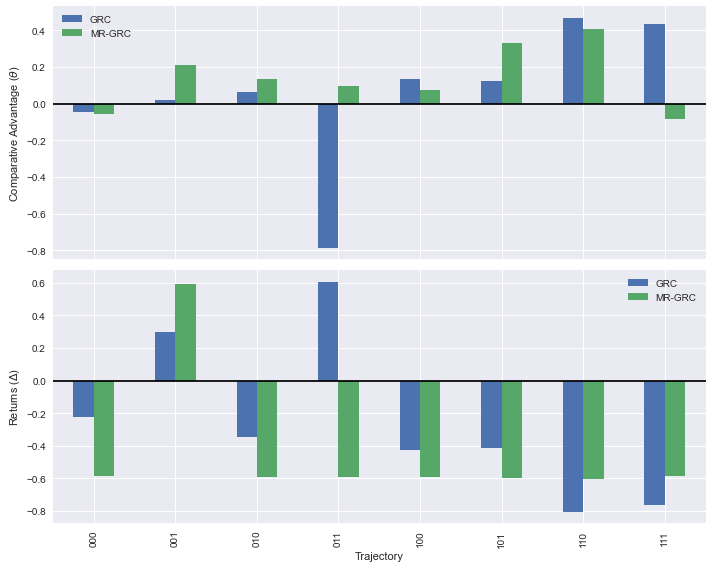

In [97]:
plt.style.use('seaborn')

fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

# Theta
theta_all[[ 'theta_normal', 'theta_misclass']].plot.bar(ax=ax[0], legend=False)

# Returns
returns_all[['returns_normal', 'returns_misclass']].plot.bar(ax=ax[1], legend=False)

ax[0].legend(['GRC', 'MR-GRC'])
ax[1].legend(['GRC', 'MR-GRC'])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")


plt.tight_layout()\

plt.savefig("../results/figures/mr-theta.png", dpi=300)

## Number of Times Adopted

In [99]:
num_adoption_df = (
    pd.read_csv("../results/data/num_adoption.csv")
)

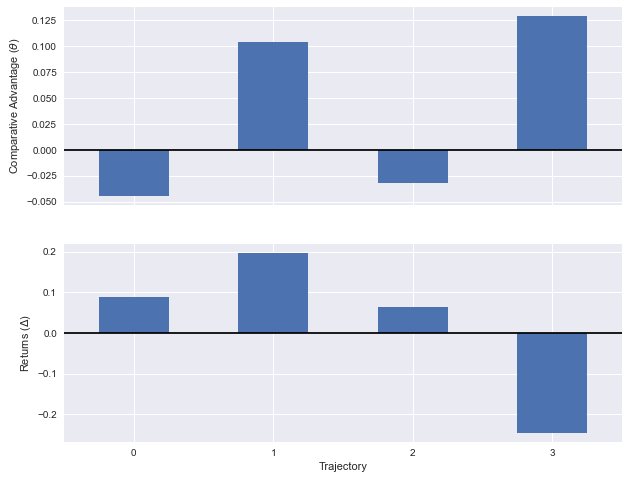

In [105]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

num_adoption_df['theta'].plot.bar(ax=ax[0])

num_adoption_df['returns'].plot.bar(ax=ax[1])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.savefig("../results/figures/num_adoption.png", dpi=300)

## Do Weak-ID Procedure

In [18]:
def weak_id_test(res, start=-100, stop=100, inc=0.1, adoption_col = 'impmaize'):
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros((ranger.size, trajectories.size))
    for i, phi in enumerate(tqdm(ranger)):
        for j, traj in enumerate(trajectories):
            test = f"trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001)"
            mat[i, j] = res.t_test(test).pvalue
            
    df= pd.DataFrame(columns = trajectories,
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def weak_id_joint_test(res, start=-100, stop=100, inc=0.1, adoption_col='impmaize'):
    
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros(ranger.size)
    
    for i, phi in enumerate(tqdm(ranger)):
        joint_test_list = [f"(trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001))" \
            for traj in trajectories]
    
        joint_test = ' , '.join(joint_test_list)
        mat[i] = res.f_test(joint_test).pvalue

    df= pd.DataFrame(columns = ['joint'],
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def phi_ci(weak_id_df):
    
    phi_p_min = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].min()
    phi_p_max = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].max()
    
    phi_df = pd.DataFrame(
        index = ['min', 'max'],
        columns = weak_id_df.columns
    )
    
    for col, mi, ma in zip(weak_id_df.columns, phi_p_min, phi_p_max):
        try:
            phi_df.loc['min', col] = weak_id_df.index[weak_id_df[col] == mi].values[0]
            phi_df.loc['max', col] = weak_id_df.index[weak_id_df[col] == ma].values[0]
        except IndexError:
            print(f"""Might be NaNs: 
                  phi_min = {phi_p_min.values[0]}
                  phi_max = {phi_p_max.values[0]}
                  """)
        
    return phi_df

In [19]:
weak_id_test = weak_id_test(sr, adoption_col='impmaize_misclass')

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: r_matrix and params are not aligned

In [ ]:
joint_test = weak_id_joint_test(sr, adoption_col='impmaize_misclass')

: 

In [ ]:
phi_ci(weak_id_test)

: 

In [ ]:
phi_ci(joint_test)

: 